In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import sys

Mounted at /content/drive/


### https://www.kaggle.com/code/thithikshunathr/audio-deepfake-detection-lj-speech-and-wavefake

In [ ]:
import os

paths = []
labels = []

fake_root_dir = '/content/drive/MyDrive/wavefake/ljspeech_melgan'
real_root_dir = '/content/drive/MyDrive/wavefake/wavs'

for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('fake')

print('Dataset is loaded')

Dataset is loaded


In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
print(df['label'].value_counts())

label
fake    4550
Name: count, dtype: int64


## Sample Fake Audio

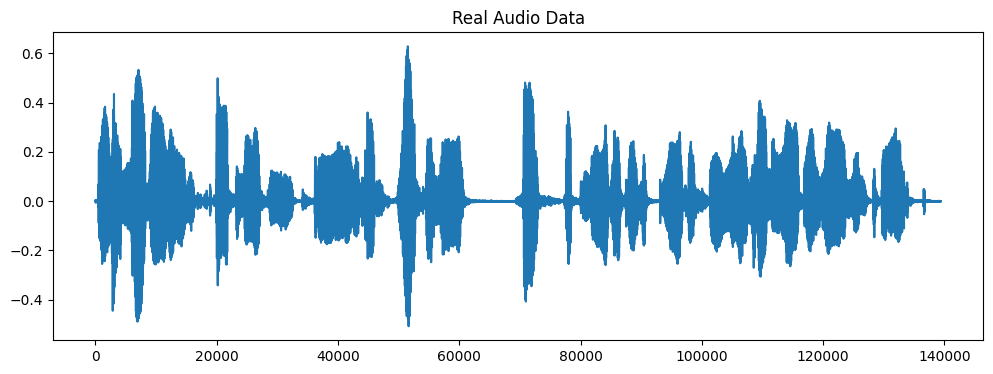

In [ ]:
real_audio_sample1 = '/content/drive/MyDrive/wavefake/wavs/LJ001-0048.wav'
real_ad, real_sr = librosa.load(real_audio_sample1)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

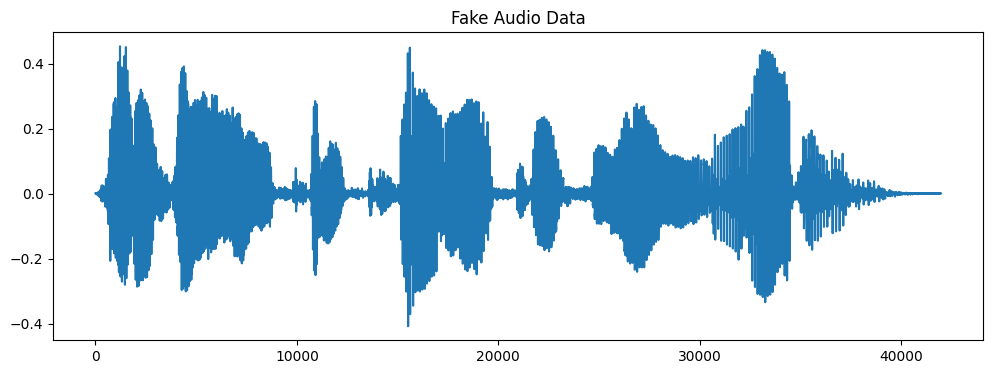

In [ ]:
fake_audio_sample1 = '/content/drive/MyDrive/wavefake/ljspeech_melgan/LJ001-0002_gen.wav'
fake_ad, fake_sr = librosa.load(fake_audio_sample1)
plt.figure(figsize= (12,4))
plt.plot(fake_ad)
plt.title('Fake Audio Data')
plt.show()

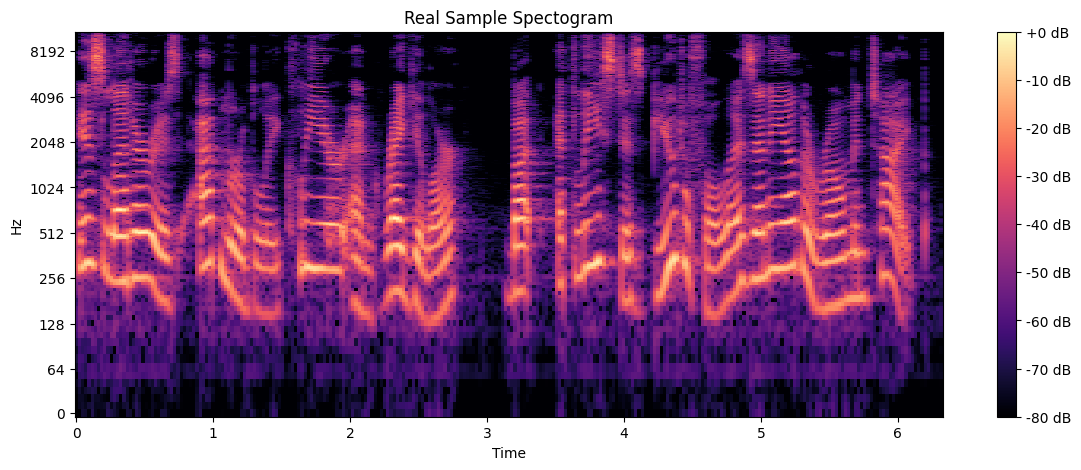

In [ ]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Sample Spectogram")
plt.show()

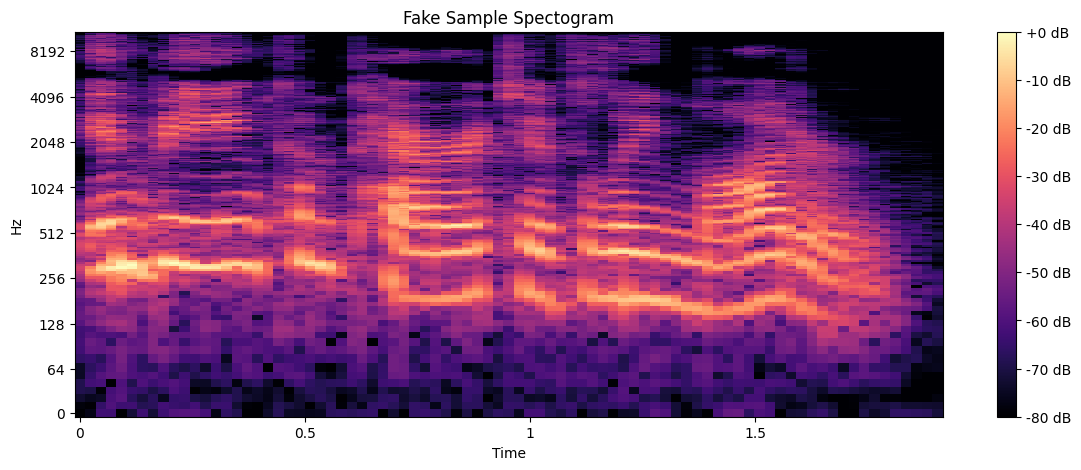

In [ ]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Fake Sample Spectogram")
plt.show()

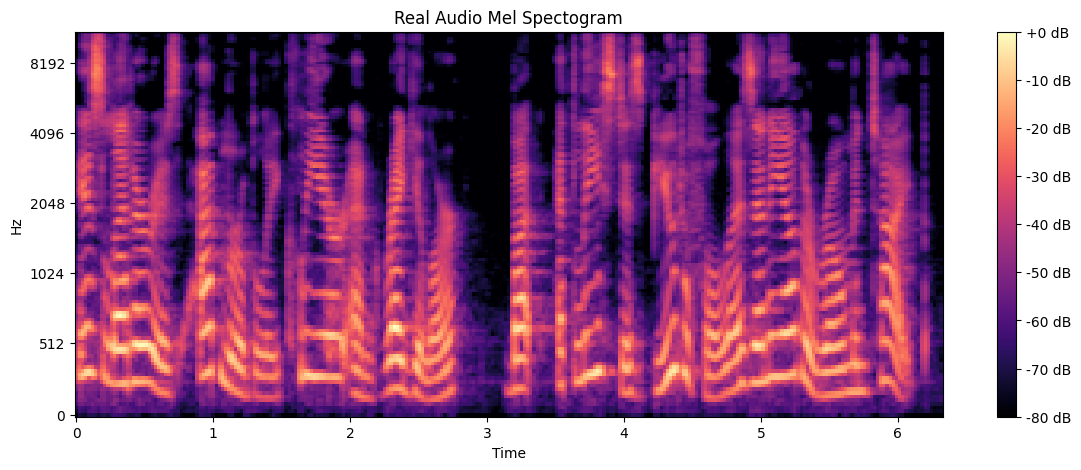

In [ ]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = fake_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

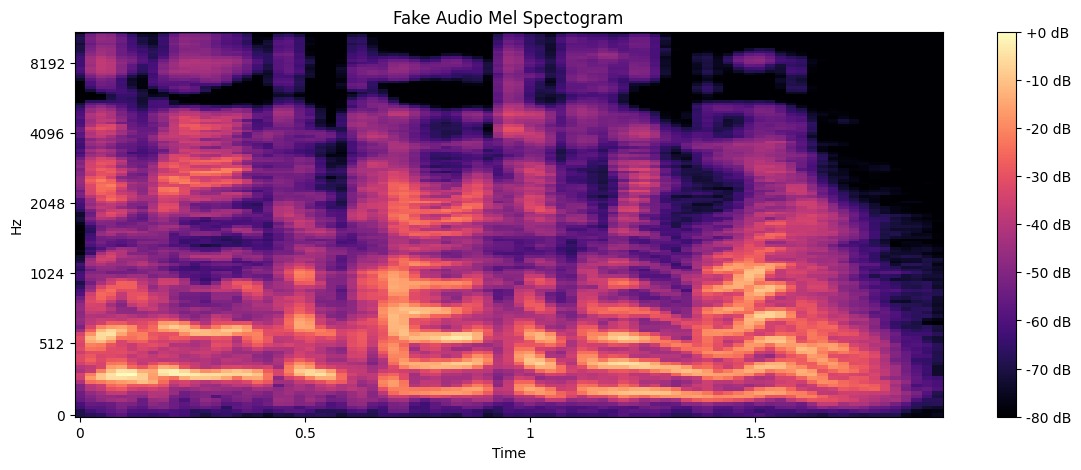

In [ ]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()



** Generative Adversarial Network **

A GAN, or Generative Adversarial Network, is a generative model that simultaneously trains two models: a generative model G
 that captures the data distribution, and a discriminative model D
 that estimates the probability that a sample came from the training data rather than G. The training procedure for G
 is to maximize the probability of D
 making a mistake.

## zero crossing rate

In [ ]:
import librosa
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import IPython.display as ipd
import scipy as spp

In [ ]:
x_real,s_real = librosa.load('/content/drive/MyDrive/wavefake/wavs/LJ001-0048.wav')
zero_crossings_real = librosa.zero_crossings(x_real, pad=False)
print(sum(zero_crossings_real))
zero_crossings_real

17183


array([False,  True, False, ..., False, False, False])

In [ ]:
x_fake,s_fake = librosa.load('/content/drive/MyDrive/wavefake/ljspeech_melgan/LJ001-0002_gen.wav')
zero_crossings_fake = librosa.zero_crossings(x_fake, pad=False)
print(sum(zero_crossings_fake))
zero_crossings_fake

3078


array([False, False, False, ..., False, False, False])

## Amplitude Envelope
### the maximum value of its amplitude in that frame

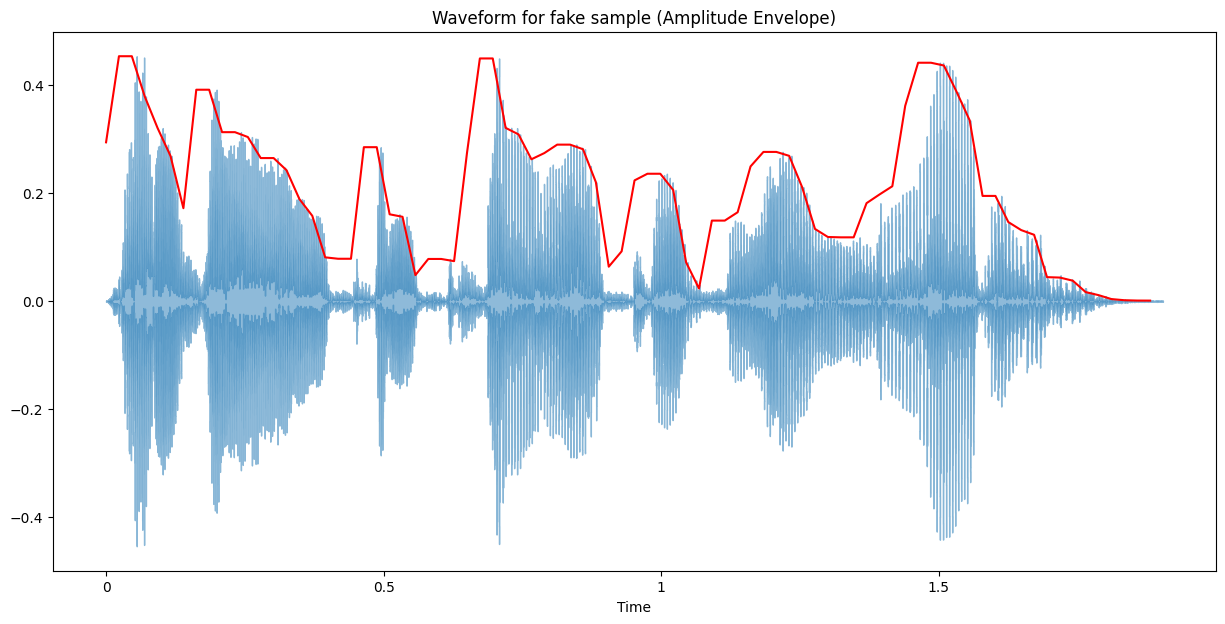

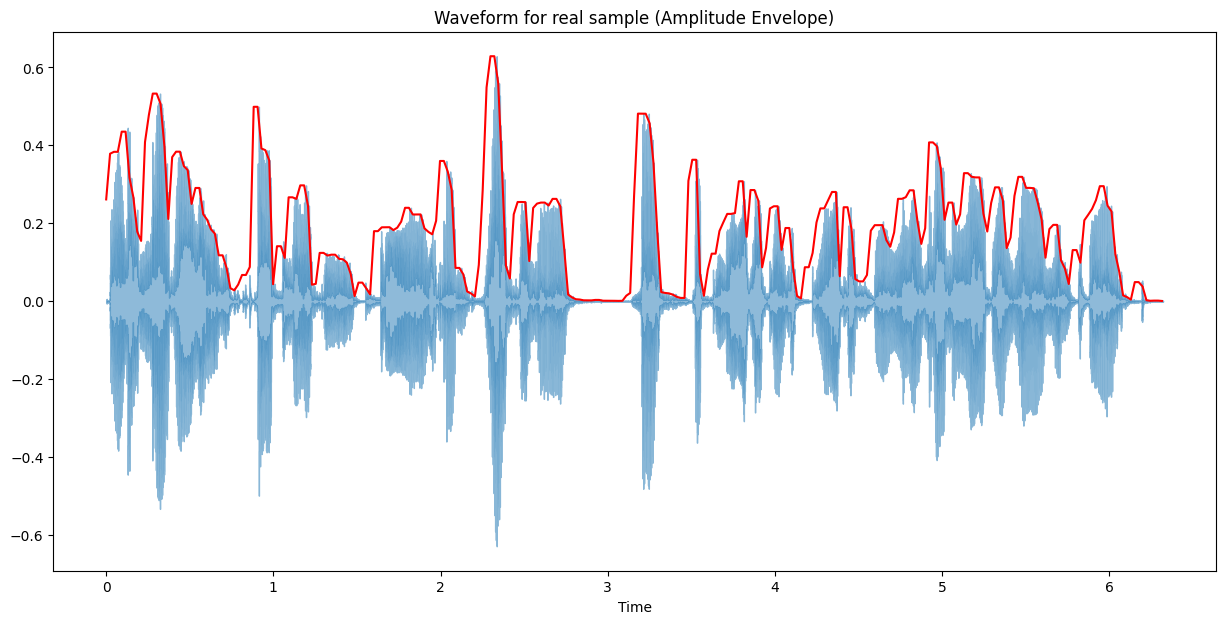

array([0.261261  , 0.37857056, 0.38345337, 0.38345337, 0.43518066,
       0.43518066, 0.3168335 , 0.26708984, 0.17843628, 0.15475464,
       0.4085083 , 0.47821045, 0.53289795, 0.53289795, 0.50683594,
       0.3977661 , 0.2111206 , 0.36987305, 0.38381958, 0.38381958,
       0.3468933 , 0.3366394 , 0.24969482, 0.29071045, 0.29071045,
       0.2232666 , 0.20922852, 0.18457031, 0.17349243, 0.11782837,
       0.11782837, 0.08590698, 0.03353882, 0.02792358, 0.04269409,
       0.06735229, 0.06735229, 0.08786011, 0.49899292, 0.49899292,
       0.39205933, 0.3876953 , 0.36169434, 0.04364014, 0.14111328,
       0.14111328, 0.1111145 , 0.26669312, 0.26669312, 0.26254272,
       0.29733276, 0.29733276, 0.2449646 , 0.04238892, 0.04464722,
       0.12405396, 0.12405396, 0.11724854, 0.1194458 , 0.1194458 ,
       0.10873413, 0.10754395, 0.09899902, 0.07009888, 0.01318359,
       0.04772949, 0.04772949, 0.0329895 , 0.01754761, 0.17980957,
       0.17980957, 0.18966675, 0.1899414 , 0.1899414 , 0.18255

In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

def amplitude_envelope(signal, frame_size=1024, hop_length=512):
    """
    Computes the Amplitude Envelope of a signal using a sliding window.

    Args:
        signal (array): The input signal.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.

    Returns:
        np.array: An array of Amplitude Envelope values.
    """
    res = []
    for i in range(0, len(signal), hop_length):
        # Get a portion of the signal
        cur_portion = signal[i:i + frame_size]
        # Compute the maximum value in the portion
        ae_val = max(cur_portion)
        # Store the amplitude envelope value
        res.append(ae_val)
    # Convert the result to a NumPy array
    return np.array(res)

def plot_amplitude_envelope(signal, name, frame_size=1024, hop_length=512):
    """
    Plots the waveform of a signal with the overlay of Amplitude Envelope values.

    Args:
        signal (array): The input signal.
        name (str): The name of the signal for the plot title.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.
    """
    # Compute the amplitude envelope
    ae = amplitude_envelope(signal, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(ae))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Display the waveform of the signal
    librosa.display.waveshow(signal, alpha=0.5)
    # Plot the amplitude envelope over time
    plt.plot(time, ae, color="r")
    # Set the title of the plot
    plt.title("Waveform for " + name + " (Amplitude Envelope)")
    # Show the plot
    plt.show()
    return ae

plot_amplitude_envelope(x_fake, "fake sample")
plot_amplitude_envelope(x_real, "real sample")

## Root Mean Square Energy

### The root mean square energy for a frame of an audio signal is obtained by taking the square root of the mean of the square of all the amplitude values in a frame.

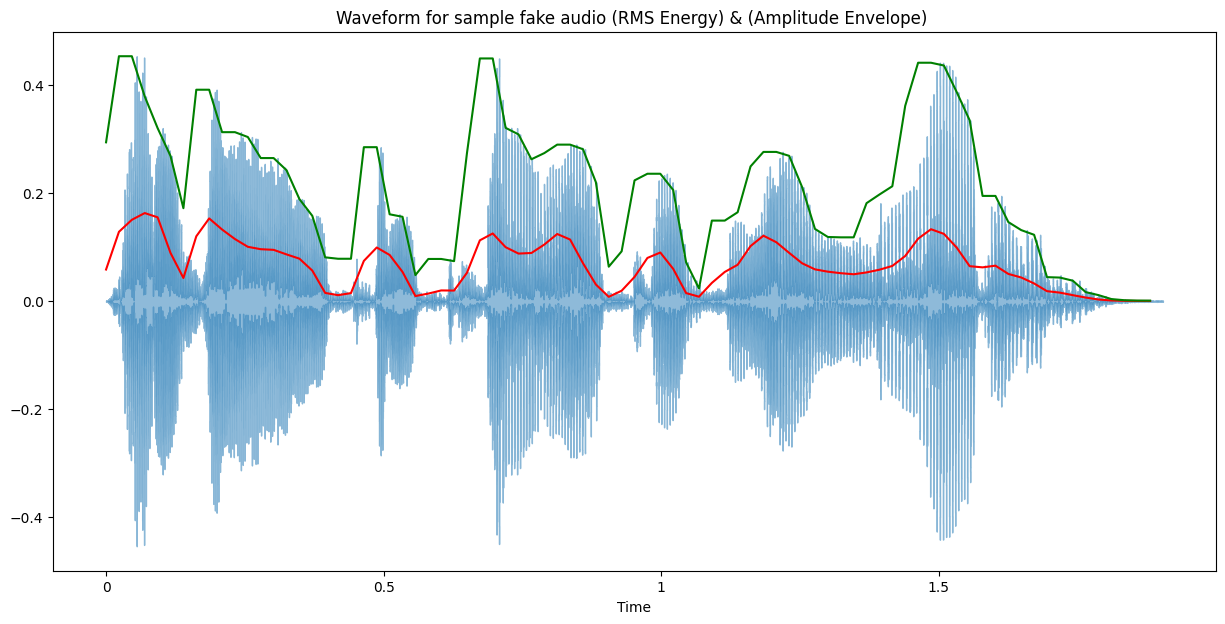

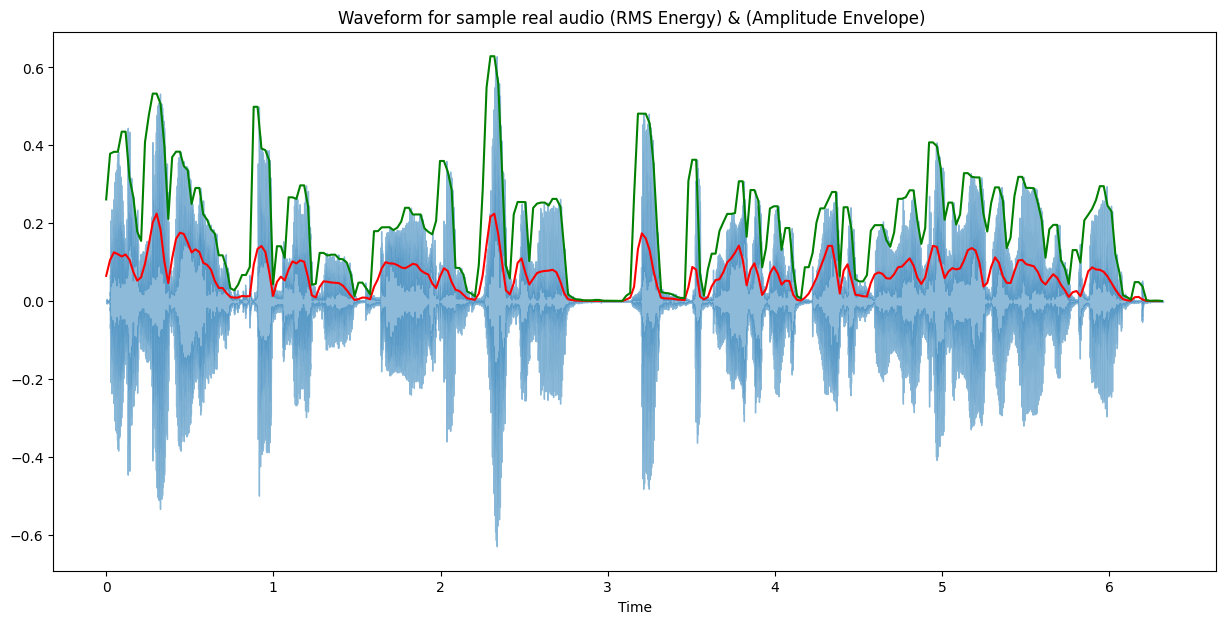

array([0.06511585, 0.10592667, 0.1255932 , 0.12082887, 0.11483089,
       0.11989693, 0.10667026, 0.07484573, 0.05270064, 0.06155349,
       0.09609485, 0.14665025, 0.20229668, 0.22470766, 0.18414831,
       0.10107273, 0.04655286, 0.11052715, 0.16013398, 0.17592742,
       0.17262057, 0.15042586, 0.12527335, 0.13323196, 0.12628323,
       0.09863416, 0.09349794, 0.08103936, 0.05204227, 0.03419677,
       0.03391925, 0.02072832, 0.01064309, 0.00921654, 0.00947729,
       0.01349626, 0.01248206, 0.01312293, 0.09301609, 0.13446265,
       0.14166272, 0.12650365, 0.07491939, 0.013543  , 0.04954584,
       0.06307685, 0.05335457, 0.08156469, 0.10227716, 0.09698122,
       0.10486633, 0.10133004, 0.06137921, 0.01478669, 0.00981021,
       0.03695723, 0.05102804, 0.04988917, 0.04802366, 0.04731344,
       0.04626363, 0.03980142, 0.02812692, 0.01473026, 0.00315288,
       0.00527691, 0.00937793, 0.00889763, 0.00508474, 0.03671807,
       0.05659658, 0.08472731, 0.10012762, 0.09702631, 0.09666

In [ ]:
def RMS_energy(signal, frame_size=1024, hop_length=512):
    """
    Computes the RMS (Root Mean Square) energy of a signal using a sliding window.

    Args:
        signal (array): The input signal.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.

    Returns:
        np.array: An array of RMS energy values.
    """
    res = []
    for i in range(0, len(signal), hop_length):
        # Extract a portion of the signal
        cur_portion = signal[i:i + frame_size]
        # Compute the RMS energy for the portion
        rmse_val = np.sqrt(1 / len(cur_portion) * sum(i**2 for i in cur_portion))
        res.append(rmse_val)
    # Convert the result to a NumPy array
    return np.array(res)

def plot_RMS_energy(signal, name, frame_size=1024, hop_length=512):
    """
    Plots the waveform of a signal with the overlay of RMS energy values.

    Args:
        signal (array): The input signal.
        name (str): The name of the signal for the plot title.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.
    """

    # Compute the RMS Energy
    rmse = RMS_energy(signal, frame_size, hop_length)
    ae = amplitude_envelope(signal, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(rmse))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Display the waveform as a spectrogram-like plot
    librosa.display.waveshow(signal, alpha=0.5)
    # Plot the RMS energy values
    plt.plot(time, rmse, color="r")
    plt.plot(time, ae, color="g")
    # Set the title of the plot
    plt.title("Waveform for " + name + " (RMS Energy) & (Amplitude Envelope) ")
    plt.show()
    return rmse

plot_RMS_energy(x_fake, "sample fake audio")
plot_RMS_energy(x_real, "sample real audio")

## Crest factor

### The crest factor indicates the ratio of the highest peak level and the average intensity level of a waveform.

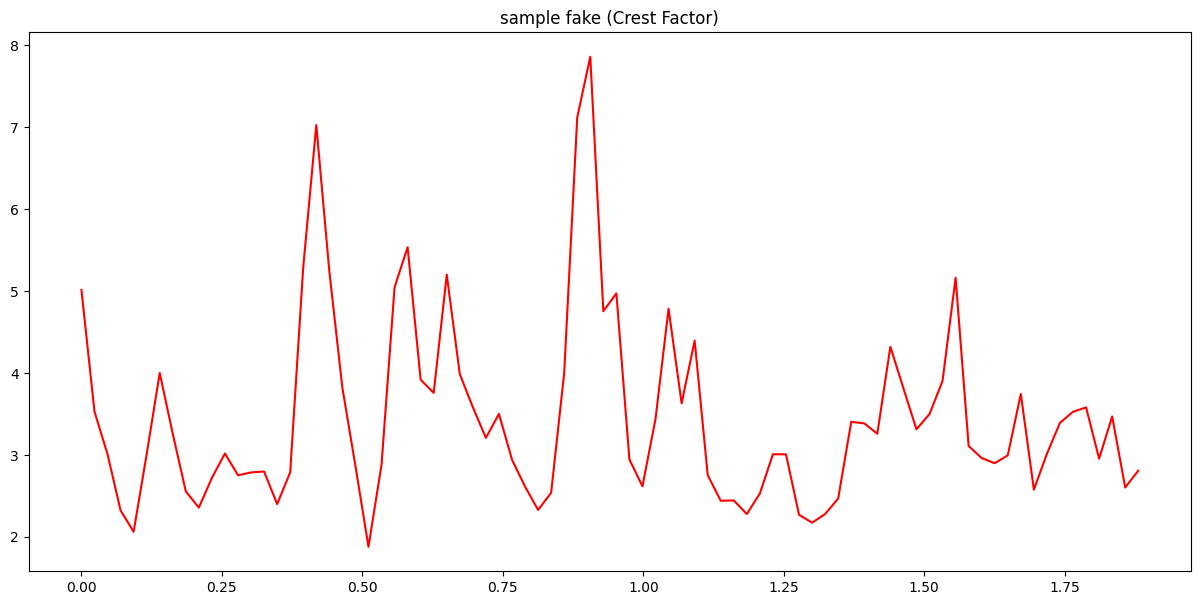

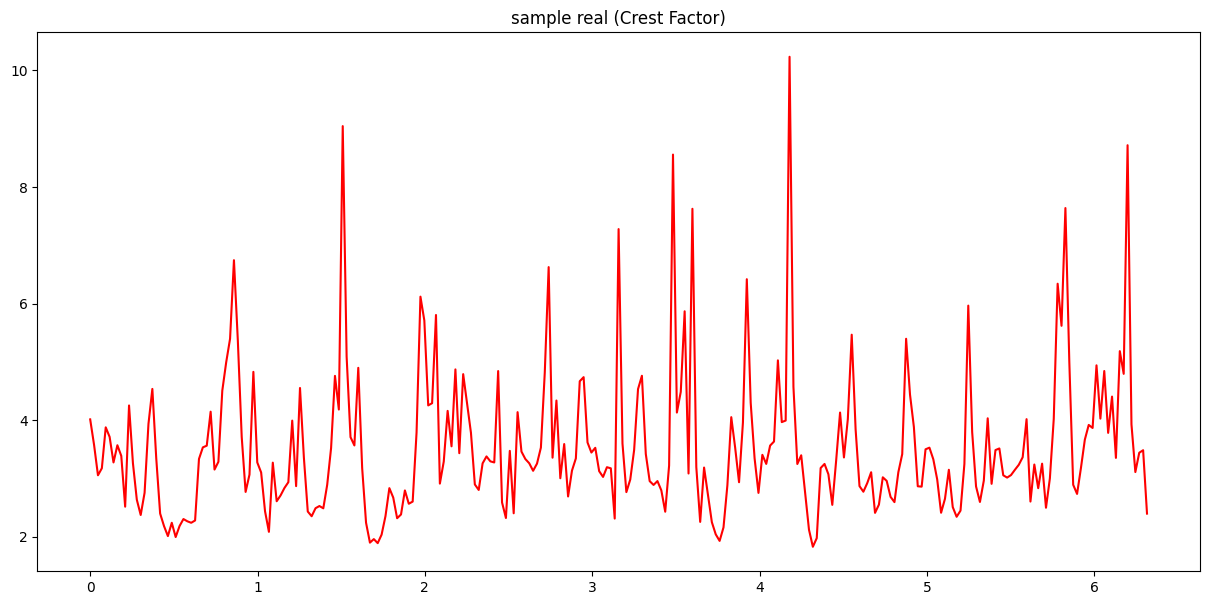

array([ 4.01224895,  3.57389269,  3.0531379 ,  3.17352449,  3.87585908,
        3.71209146,  3.27318606,  3.56853829,  3.38584659,  2.51414877,
        4.25109467,  3.26089084,  2.6342397 ,  2.37151656,  2.75232461,
        3.9354444 ,  4.53507246,  3.34644514,  2.39686526,  2.18169282,
        2.00957111,  2.23790911,  1.99319994,  2.18198739,  2.30205117,
        2.26358293,  2.23778748,  2.27753909,  3.33368312,  3.53216346,
        3.56106297,  4.14442551,  3.15122927,  3.2846859 ,  4.50488167,
        4.9904405 ,  5.39592696,  6.74399593,  5.36458723,  3.71101511,
        2.76755474,  3.06469664,  4.82778036,  3.27416728,  3.10128996,
        2.43601259,  2.08256771,  3.26971273,  2.60755291,  2.70715028,
        2.83535007,  2.93430037,  3.99100286,  2.86669408,  4.5510974 ,
        3.35668994,  2.43109375,  2.35017997,  2.48786389,  2.52520885,
        2.48620264,  2.8898656 ,  3.5197255 ,  4.75883616,  4.18144688,
        9.04496548,  5.08955391,  3.70767249,  3.5650671 ,  4.89

In [ ]:
def crest_factor(signal, frame_size=1024, hop_length=512):
    """
    Computes the crest factor of a signal using a sliding window.

    Args:
        signal (array): The input signal.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.

    Returns:
        np.array: An array of crest factor values.
    """
    res = []
    for i in range(0, len(signal), hop_length):
        # Get a portion of the signal
        cur_portion = signal[i:i + frame_size]
        # Compute the RMS energy for the portion
        rmse_val = np.sqrt(1 / len(cur_portion) * sum(i ** 2 for i in cur_portion))
        # Compute the crest factor
        crest_val = max(np.abs(cur_portion)) / rmse_val
        # Store the crest factor value
        res.append(crest_val)
    # Convert the result to a NumPy array
    return np.array(res)

def plot_crest_factor(signal, name, frame_size=1024, hop_length=512):
    """
    Plots the crest factor of a signal over time.
     Args:
        signal (array): The input signal.
        name (str): The name of the signal for the plot title.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.
    """
    # Compute the crest factor
    crest = crest_factor(signal, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(crest))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Plot the crest factor over time
    plt.plot(time, crest, color="r")
    # Set the title of the plot
    plt.title(name + " (Crest Factor)")
    # Show the plot
    plt.show()
    return crest

plot_crest_factor(x_fake, "sample fake")
plot_crest_factor(x_real, "sample real")

## Band Width Energy

### The band energy ratio is a metric used to quantify the ratio of the energies of the lower frequencies to that of the higher frequencies in a given time frame.

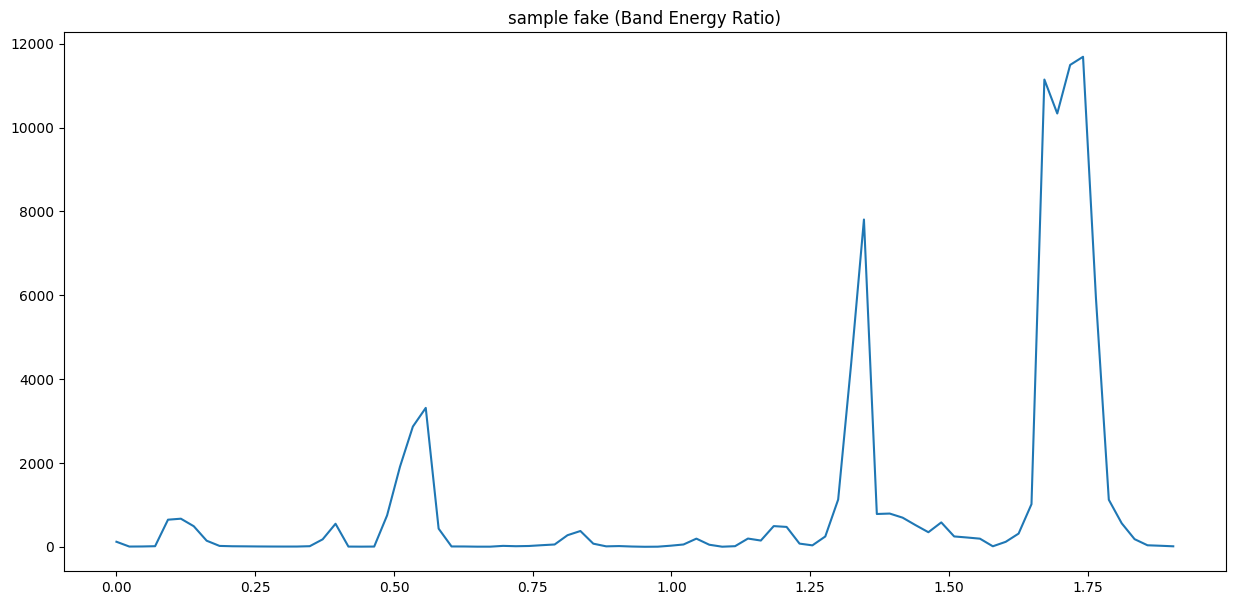

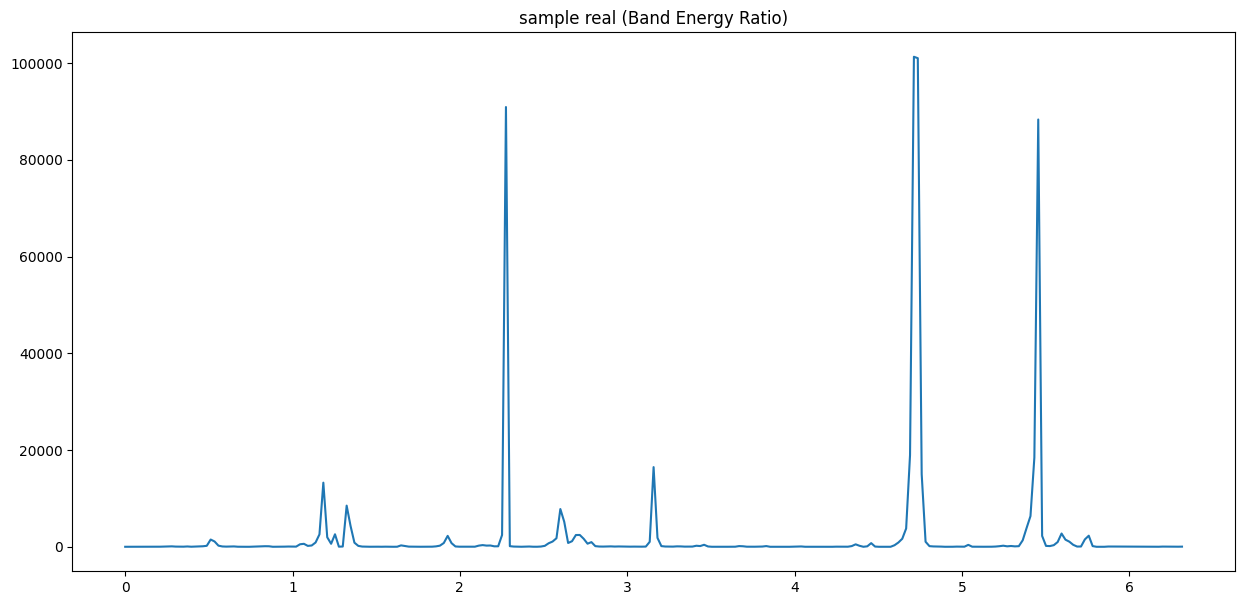

In [ ]:
def find_split_freq_bin(spec, split_freq, sample_rate, frame_size=1024, hop_length=512):
    """
    Calculate the bin index corresponding to a given split frequency.

    Args:
        spec (array): The spectrogram.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        int: The bin index corresponding to the split frequency.
    """
    # Calculate the range of frequencies
    range_of_freq = sample_rate / 2
    # Calculate the change in frequency per bin
    change_per_bin = range_of_freq / spec.shape[0]
    # Calculate the bin corresponding to the split frequency
    split_freq_bin = split_freq / change_per_bin
    return int(np.floor(split_freq_bin))

def band_energy_ratio(signal, split_freq, sample_rate, frame_size=1024, hop_length=512):
    """
    Compute the band energy ratio (BER) of a signal.

    Args:
        signal (array): The input signal.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        ndarray: The band energy ratios for each frame of the signal.
    """
    # Compute the spectrogram of the signal
    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Find the bin corresponding to the split frequency
    split_freq_bin = find_split_freq_bin(spec, split_freq, sample_rate, frame_size, hop_length)
    # Extract the magnitude and transpose it
    modified_spec = np.abs(spec).T
    res = []
    for sub_arr in modified_spec:
        # Compute the energy in the low-frequency range
        low_freq_density = sum(i ** 2 for i in sub_arr[:split_freq_bin])
        # Compute the energy in the high-frequency range
        high_freq_density = sum(i ** 2 for i in sub_arr[split_freq_bin:])
        # Compute the band energy ratio
        ber_val = low_freq_density / high_freq_density
        res.append(ber_val)
    return np.array(res)

def plot_band_energy_ratio(signal, split_freq, sample_rate, name, frame_size=1024, hop_length=512):
    """
    Plot the band energy ratio (BER) of a signal over time.

    Args:
        signal (ndarray): The input signal.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        name (str): The name of the signal for the plot title.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.
    """
    # Compute the band energy ratio (BER)
    ber = band_energy_ratio(signal, split_freq, sample_rate, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(ber))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Plot the BER over time
    plt.plot(time, ber)
    # Set the title of the plot
    plt.title(name + " (Band Energy Ratio)")
    # Show the plot
    plt.show()

plot_band_energy_ratio(x_fake, 2048, s_fake, "sample fake")
plot_band_energy_ratio(x_real, 2048, s_real, "sample real")

## Spectral Centroid

### average frequency of a signal’s spectrum in a given time frame

### Sounds with higher spectral centroids tend to have a brighter or more treble-oriented quality, while lower centroid values are associated with a rather darker or bass-oriented character.

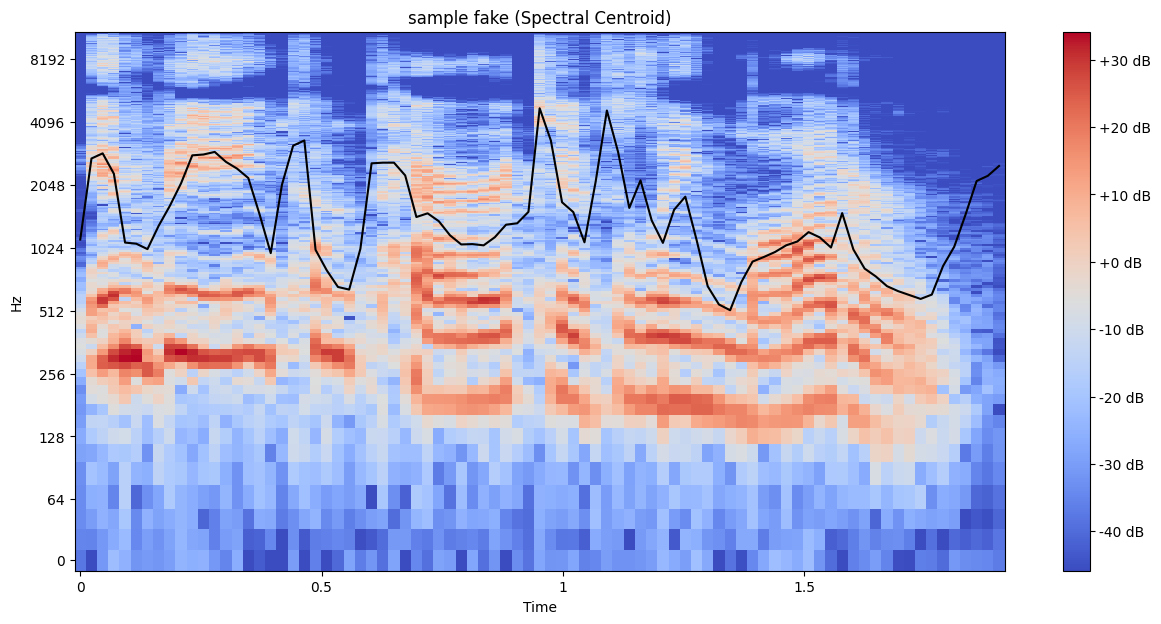

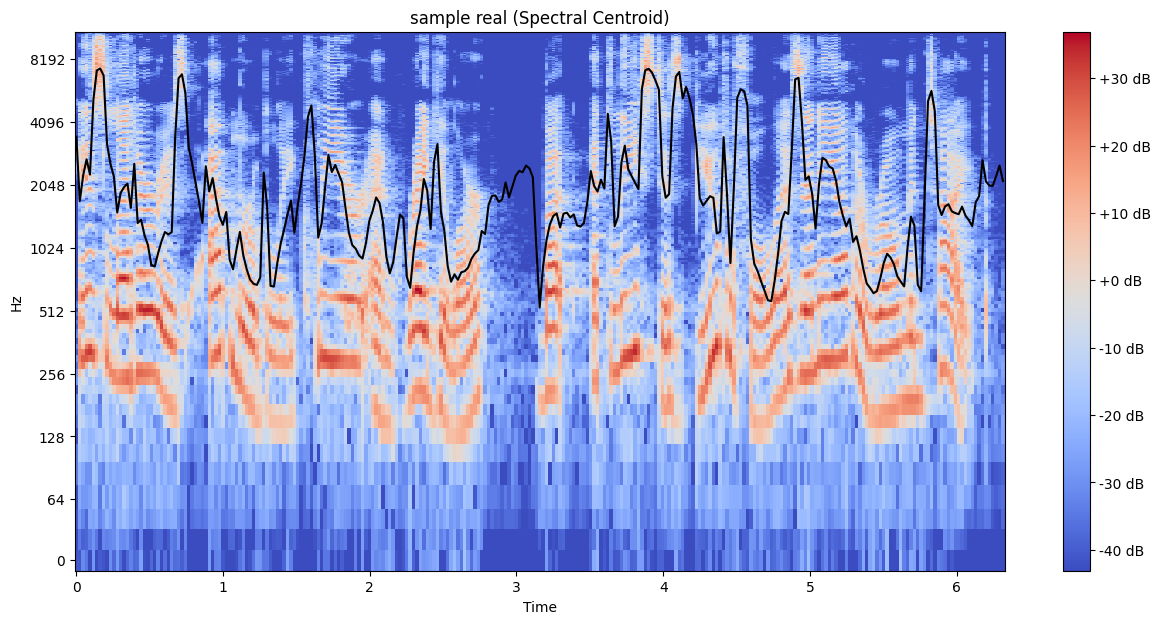

array([161.74065353,  79.4365163 , 105.60318037, 126.0560895 ,
       106.51335776, 242.32856847, 334.96461691, 342.65176228,
       317.34364878, 149.53409691, 119.90294687, 104.54059754,
        70.10485183,  87.08573914,  92.74136522,  96.54097311,
        73.77811634, 119.9678176 ,  62.4546826 ,  64.83414777,
        54.6917705 ,  49.09167574,  39.44568724,  38.67290833,
        44.85528059,  51.10116077,  56.57790121,  55.09639793,
        56.50809546, 158.30884854, 307.77398134, 321.25089367,
       261.24551769, 143.15984002, 119.91204423,  97.10392133,
        78.98719618,  62.54136239, 116.71064947,  88.43772503,
       102.49733996,  81.49923768,  67.14477376,  61.23340736,
        70.56386624,  41.71257832,  37.51245253,  46.62921729,
        56.60352476,  43.81561275,  37.59124018,  33.50445148,
        32.00760618,  31.59441536,  34.39455264, 109.00838182,
        75.01529412,  31.27295326,  31.03960891,  40.36768167,
        49.98399195,  58.23101166,  68.96154663,  79.87

In [ ]:
def spectral_centroid(signal, sample_rate, frame_size=1024, hop_length=512):
    """
    Compute the Spectral Centroid of a signal.

    Args:
        signal (array): The input signal.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        ndarray: The spectral centroids for each frame of the signal.
    """
    # Compute the spectrogram of the signal
    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Extract the magnitude and transpose it
    modified_spec = np.abs(spec).T
    res = []
    for sub_arr in modified_spec:
        # Compute the spectral centroid
        sc_val = sc(sub_arr)
        # Store the value of spectral centroid for current frame
        res.append(sc_val)
    return np.array(res)

def sc(arr):
    """
    Computes the spectral centroid in a signal.

    Args:
        arr (array): Frequency domain array for current frame.

    Returns:
        float: The spectral centroid value for current frame.
    """
    res = 0
    for i in range(0, len(arr)):
        # Compute weighted sum
        res += i*arr[i]
    return res/sum(arr)

def bin_to_freq(spec, bin_val, sample_rate, frame_size=1024, hop_length=512):
    """
    Calculate the frequency corresponding to a given bin value

    Args:
        spec (array): The spectrogram.
        bin_val (): The bin value.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        int: The bin index corresponding to the split frequency.
    """
    # Calculate the range of frequencies
    range_of_freq = sample_rate / 2
    # Calculate the change in frequency per bin
    change_per_bin = range_of_freq / spec.shape[0]
    # Calculate the frequency corresponding to the bin
    split_freq = bin_val*change_per_bin
    return split_freq

def plot_spectral_centroid(signal, sample_rate, name, frame_size=1024, hop_length=512, col = "black"):
    """
    Plot the spectral centroid of a signal over time.

    Args:
        signal (ndarray): The input signal.
        sample_rate (int): The sample rate of the audio.
        name (str): The name of the signal for the plot title.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.
    """
    # Compute the STFT
    spectrogram = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Convert the STFT to dB scale
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))
    # Compute the Spectral Centroid
    sc_arr = spectral_centroid(signal, sample_rate, frame_size, hop_length)
    # Compute corresponding frequencies:
    sc_freq_arr = bin_to_freq(spectrogram_db, sc_arr, sample_rate, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(sc_arr))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Display the Spectrogram
    librosa.display.specshow(spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
    # Add a colorbar to show the magnitude scale
    plt.colorbar(format='%+2.0f dB')
    # Plot the Spectral Centroid over time
    plt.plot(time, sc_freq_arr, color=col)
    # Set the title of the plot
    plt.title(name + " (Spectral Centroid)")
    # Show the plot
    plt.show()
    return sc_arr

plot_spectral_centroid(x_fake, s_fake, "sample fake")
plot_spectral_centroid(x_real, s_real, "sample real")

# PCA

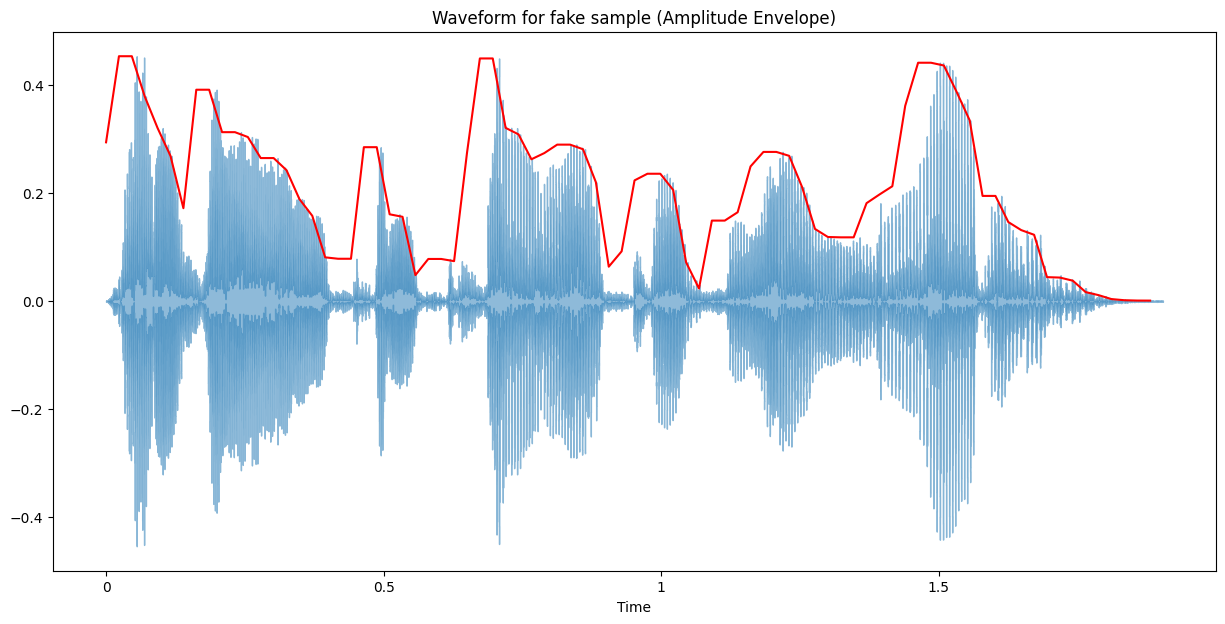

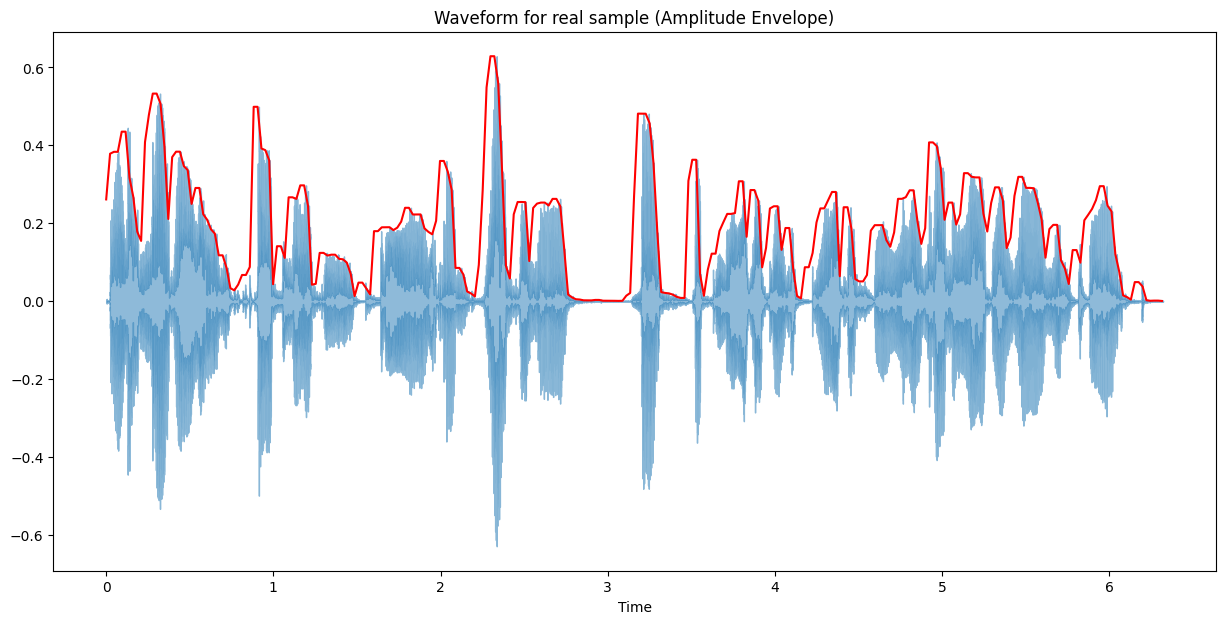

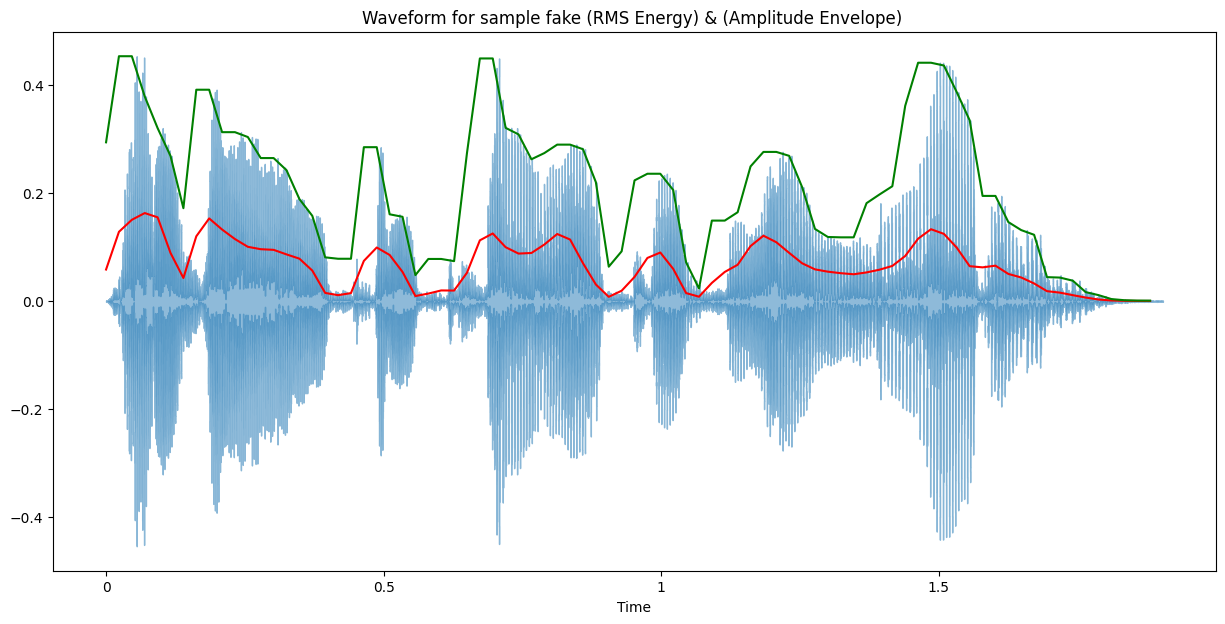

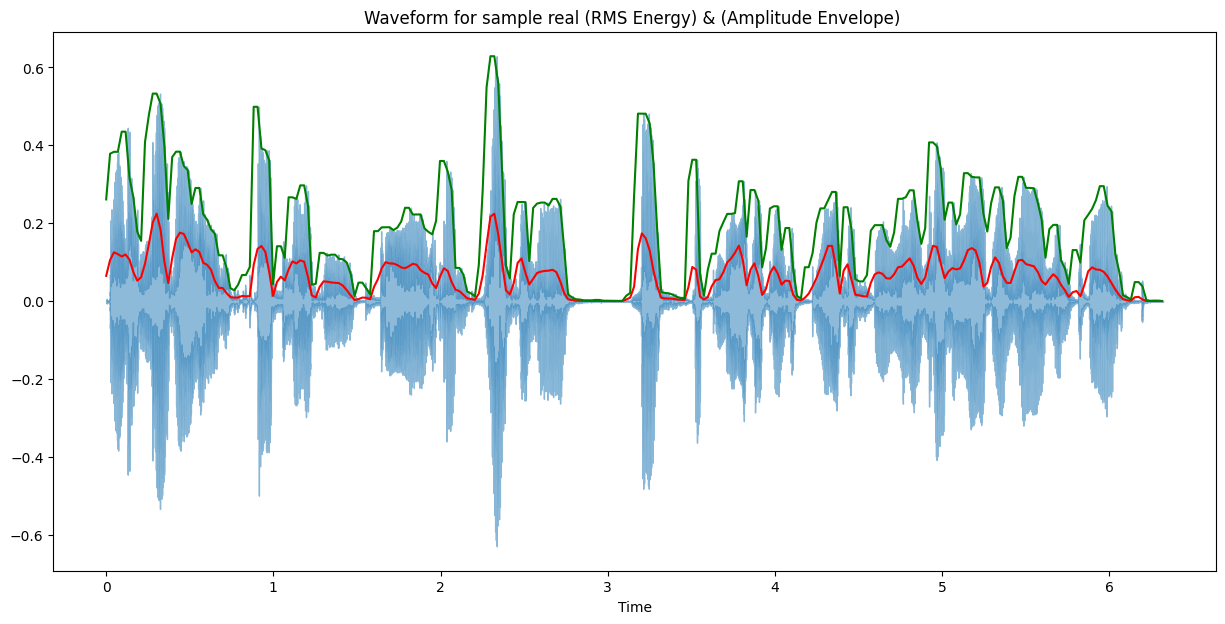

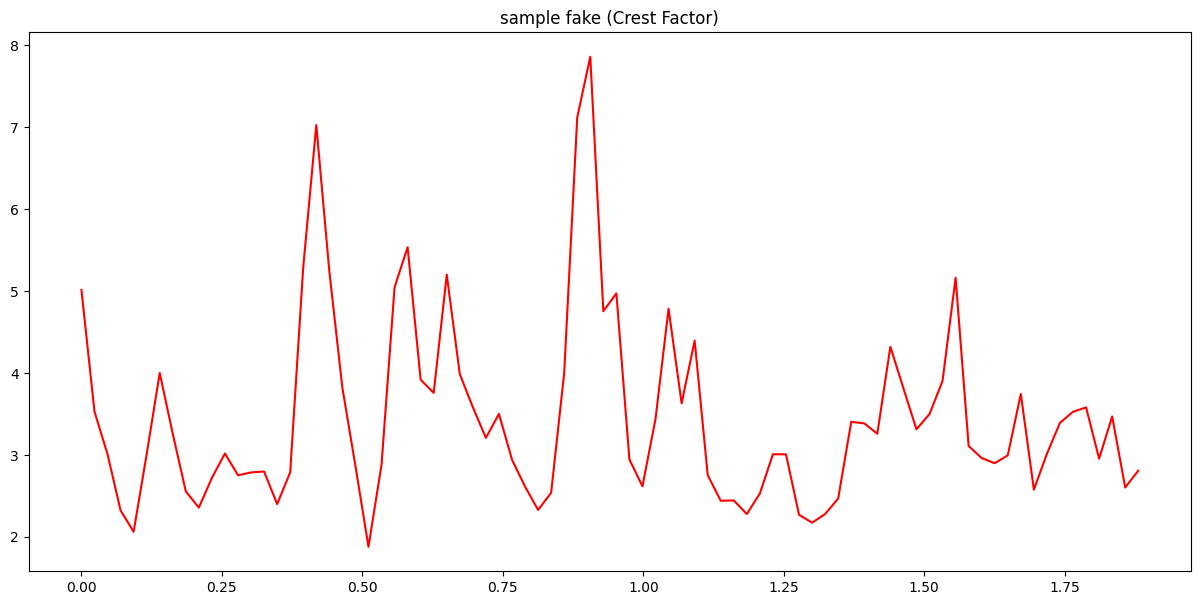

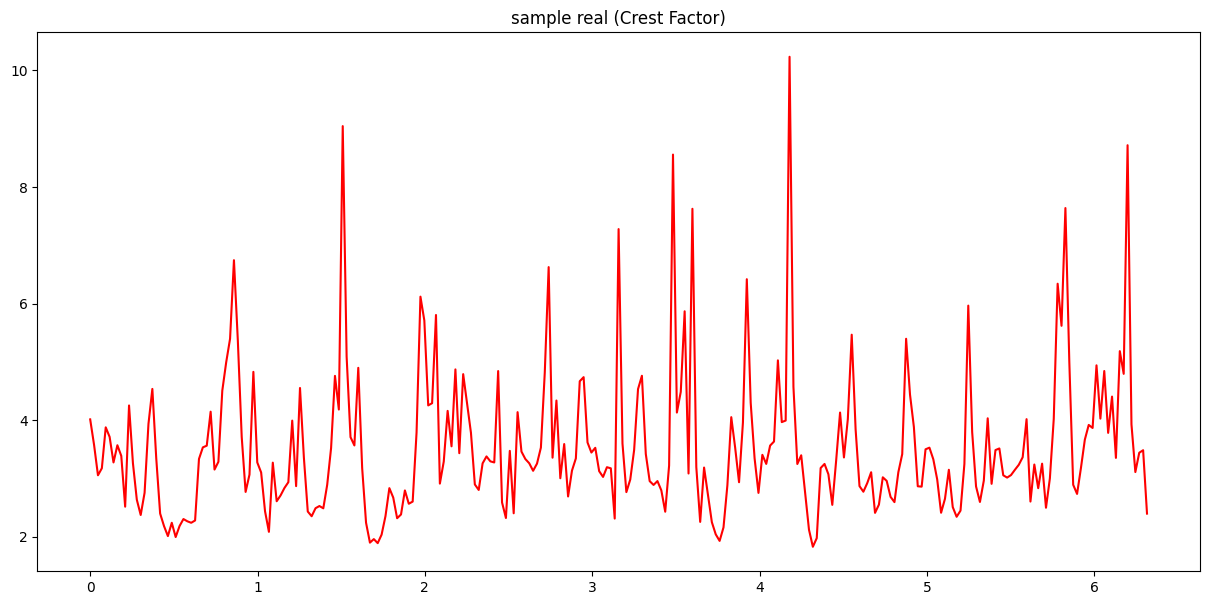

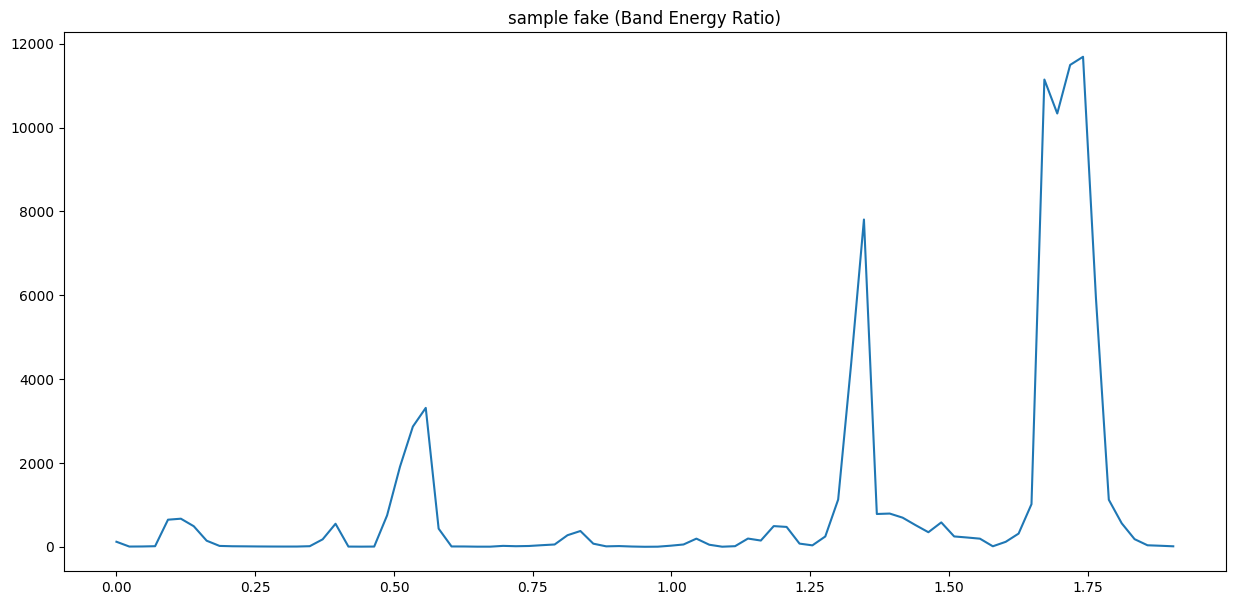

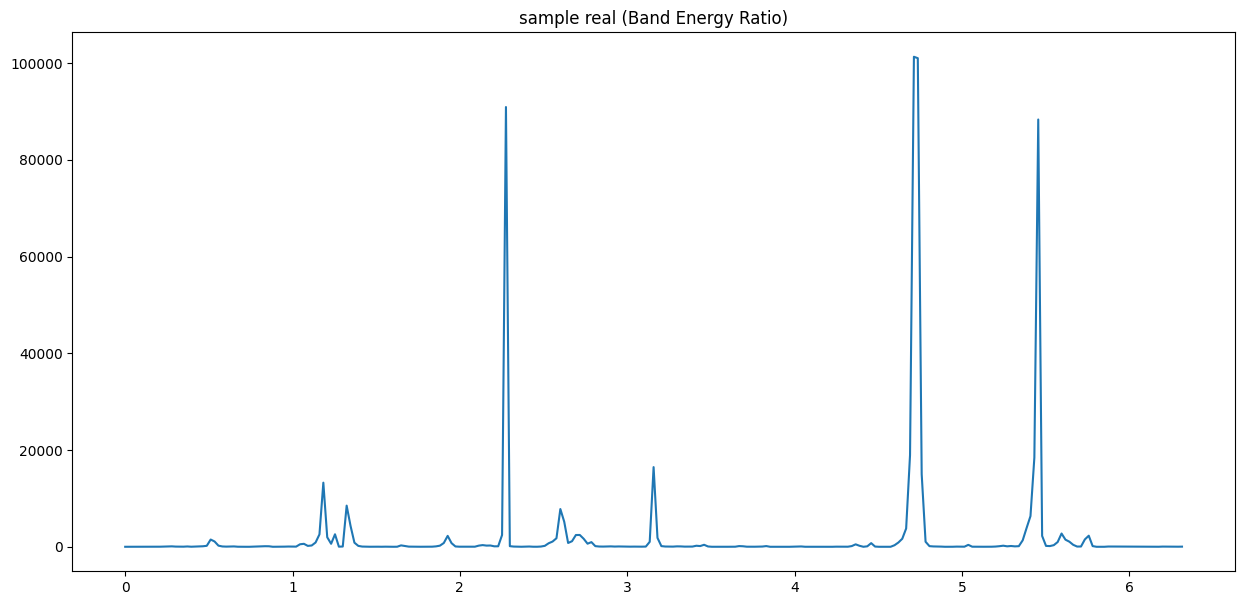

In [ ]:
combined_df_real = pd.DataFrame([])
combined_df_fake = pd.DataFrame([])

combined_df_real['amplitude_envelope'] = plot_amplitude_envelope(x_fake, "fake sample")
combined_df_fake['amplitude_envelope'] = plot_amplitude_envelope(x_real, "real sample")

combined_df_real['RMS_energy'] = plot_RMS_energy(x_fake, "sample fake")
combined_df_fake['RMS_energy'] = plot_RMS_energy(x_real, "sample real")

combined_df_real['crest_factor'] = plot_crest_factor(x_fake, "sample fake")
combined_df_fake['crest_factor'] = plot_crest_factor(x_real, "sample real")

combined_df_real['band_energy_ratio'] = plot_band_energy_ratio(x_fake, 2048, s_fake, "sample fake")
combined_df_fake['band_energy_ratio'] = plot_band_energy_ratio(x_real, 2048, s_real, "sample real")


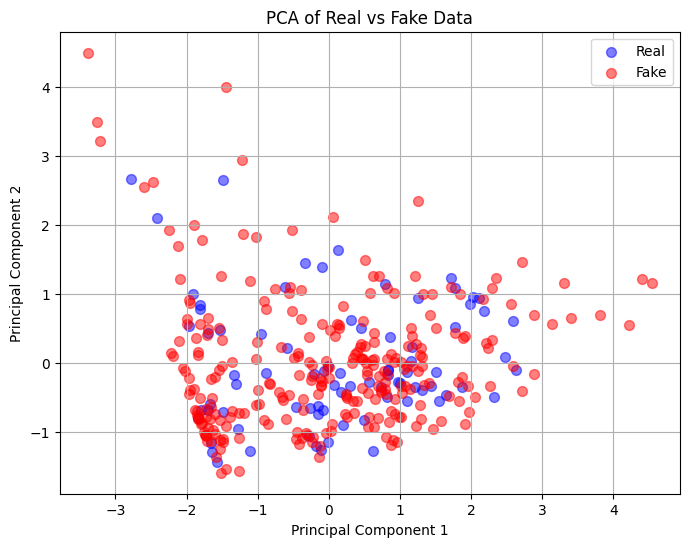

In [ ]:
combined_df_real['Label'] = 'Real'
combined_df_fake['Label'] = 'Fake'

combined_df = pd.concat([combined_df_real, combined_df_fake], ignore_index=True)

numerical_cols = ['amplitude_envelope', 'RMS_energy', 'crest_factor']

combined_df[numerical_cols] = combined_df[numerical_cols].replace('None', pd.NA)

medians = combined_df[numerical_cols].median()
combined_df[numerical_cols] = combined_df[numerical_cols].fillna(medians)

from sklearn.preprocessing import StandardScaler

features = ['amplitude_envelope', 'RMS_energy', 'crest_factor']

x = combined_df.loc[:, features].values

x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

final_df = pd.concat([principal_df, combined_df[['Label']]], axis=1)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

colors = {'Real': 'blue', 'Fake': 'red'}
for label, color in colors.items():
    indices_to_keep = final_df['Label'] == label
    ax.scatter(final_df.loc[indices_to_keep, 'PC1'],
               final_df.loc[indices_to_keep, 'PC2'],
               c=color,
               s=50,
               label=label,
               alpha=0.5)

ax.legend()
ax.grid()
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Real vs Fake Data')
plt.show()
